# Neo4j - Quick Introduction

In [1]:
from langchain_neo4j import Neo4jGraph
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

## Connecting to Neo4j Database

In [2]:
graph = Neo4jGraph(
    url="bolt://localhost:7688",
    username="neo4j",
    password="testpass",
    database="neo4j"
)

In [3]:
query = "SHOW DATABASES"
graph.query(query)

[{'name': 'neo4j',
  'type': 'standard',
  'aliases': [],
  'access': 'read-write',
  'address': 'localhost:7687',
  'role': 'primary',
  'writer': True,
  'requestedStatus': 'online',
  'currentStatus': 'online',
  'statusMessage': '',
  'default': True,
  'home': True,
  'constituents': []},
 {'name': 'system',
  'type': 'system',
  'aliases': [],
  'access': 'read-write',
  'address': 'localhost:7687',
  'role': 'primary',
  'writer': True,
  'requestedStatus': 'online',
  'currentStatus': 'online',
  'statusMessage': '',
  'default': False,
  'home': False,
  'constituents': []}]

In [4]:
query = """
MATCH (n)
DETACH DELETE n
"""
graph.query(query)

[]

## Creating a Simple Graph

In [5]:
# Create person nodes
people = [
    {"name": "Alice", "age": 30, "city": "New York"},
    {"name": "Bob", "age": 35, "city": "San Francisco"},
    {"name": "Charlie", "age": 28, "city": "Seattle"},
    {"name": "Diana", "age": 32, "city": "Boston"},
    {"name": "Eve", "age": 27, "city": "Austin"}
]

for person in people:
    query = f"""
    CREATE (p:Person {{name: '{person['name']}', age: {person['age']}, city: '{person['city']}'}});
    """
    graph.query(query)

In [6]:
# Create KNOWS relationships
relationships = [
    ("Alice", "Bob", "colleague"),
    ("Alice", "Charlie", "friend"),
    ("Bob", "Diana", "friend"),
    ("Charlie", "Eve", "colleague"),
    ("Diana", "Eve", "friend"),
    ("Bob", "Charlie", "colleague")
]

for from_person, to_person, rel_type in relationships:
    query = f"""
    MATCH (a:Person {{name: '{from_person}'}}), (b:Person {{name: '{to_person}'}})
    CREATE (a)-[:KNOWS {{type: '{rel_type}'}}]->(b);
    """
    graph.query(query)

## Querying and Visualizing the Graph

In [7]:
# Get all nodes and edges
query = "MATCH (a:Person)-[r:KNOWS]->(b:Person) RETURN a.name as source, b.name as target, r.type as type;"
results = list(graph.query(query))
df = pd.DataFrame([dict(row) for row in results])
print(df)

    source   target       type
0    Alice      Bob  colleague
1      Bob  Charlie  colleague
2    Alice  Charlie     friend
3      Bob    Diana     friend
4    Diana      Eve     friend
5  Charlie      Eve  colleague


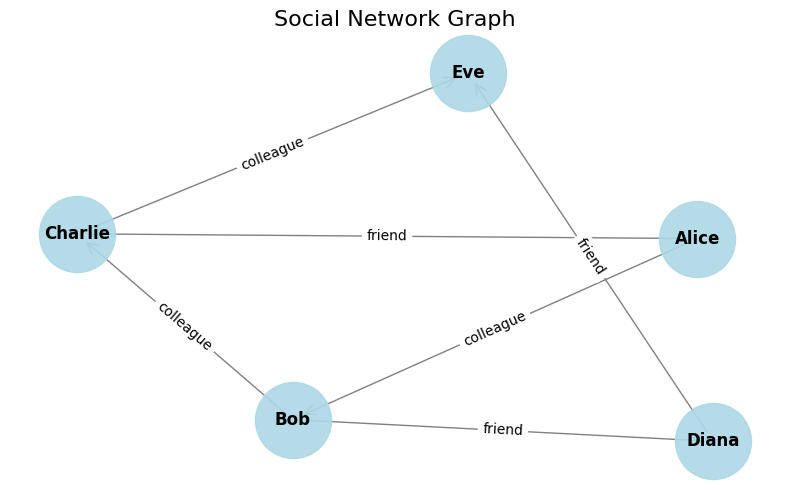

In [9]:
# Create a NetworkX graph
G = nx.DiGraph()

for row in results:
    data = dict(row)
    G.add_edge(data['source'], data['target'], type=data['type'])

# Draw the graph
plt.figure(figsize=(8, 5))
pos = nx.spring_layout(G, k=2, iterations=50)

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_color='lightblue', 
                       node_size=3000, alpha=0.9)

# Draw edges
nx.draw_networkx_edges(G, pos, edge_color='gray', 
                       arrows=True, arrowsize=20, arrowstyle='->')

# Draw labels
nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')

# Draw edge labels
edge_labels = nx.get_edge_attributes(G, 'type')
nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=10)

plt.title("Social Network Graph", fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.show()